# Exploration of CommScores metrics using the Arabidopsis leaf microbiome

In this notebook we explore the applicability of CommScores metrics for predicting interactions in microbial co-cultures.
We explore experimental datasets from a study of the Arabidopsis (AT)leaf microbiome[[1]](#1).

<a id="1">[1]</a>: Schäfer, M., Pacheco, A. R., Künzler, R., Bortfeld-Miller, M., Field, C. M., Vayena, E., Hatzimanikatis, V., & Vorholt, J. A. (2023). Metabolic interaction models recapitulate leaf microbiota ecology. Science. https://doi.org/adf5121

In [1]:
import pathlib
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme(style="whitegrid")

## Experiments

Arabidopsis seedlings were inoculated with monocultures and cocultures of the AT-LSPHERE isolates for 28-29 days.
Pre-weighted amounts of plant samples are diluted to 10^-3 or 10^-5 fold dilutions and plated on agar plates.
The plates are incubated for 1-3 days and the number of CFUs (colony forming units) are counted.

Overall, the study consisted of two experiments which followed the same protocols but differed in the strains that were used in the experiments.

In [5]:
rawdata_dir = pathlib.Path("../../data/raw/at_leaf/")

In [6]:
# Read experiment 1 data
s5_exp1 = pd.read_excel((rawdata_dir / "table_s5.xlsx"), sheet_name=0)
s5_exp1

,Sample,Treatment_name,Plant_weight_[mg],Medium,Condition,Strain,CFU,Dilution,Colonization (CFU g-1 plant weight),log10_Colonization
0,1,L15,36.7,R2A,single,Leaf15,42,0.001,1.831063e+07,7.262703
1,2,L15,22.5,R2A,single,Leaf15,53,0.001,3.768889e+07,7.576213
2,3,L15,26.5,R2A,single,Leaf15,102,0.001,6.158491e+07,7.789474
3,4,L15,16.2,R2A,single,Leaf15,123,0.001,1.214815e+08,8.084510
4,5,L15,32.9,R2A,single,Leaf15,92,0.001,4.474164e+07,7.650712
...,...,...,...,...,...,...,...,...,...,...
667,356,L15/L34,23.1,R2A,combi,Leaf15,51,0.001,3.532468e+07,7.548078
668,357,L15/L34,30.2,R2A,combi,Leaf15,57,0.001,3.019868e+07,7.479988
669,358,L15/L34,15.9,R2A,combi,Leaf15,73,0.001,7.345912e+07,7.866046
670,359,L15/L34,30.8,R2A,combi,Leaf15,128,0.001,6.649351e+07,7.822779


In [7]:
# Read experiment 2 data
s5_exp2 = pd.read_excel((rawdata_dir / "table_s5.xlsx"), sheet_name=1)
s5_exp2

,Sample,Treatment_name,Plant_weight_[mg],Medium,Condition,Strain,CFU,Dilution,Colonization (CFU g-1 plant weight),log10_Colonization
0,37,L8,18.0,R-2A+M,single,Leaf8,59.0,0.001,5.244444e+07,7.719699
1,38,L8,11.2,R-2A+M,single,Leaf8,50.0,0.001,7.142857e+07,7.853872
2,39,L8,23.0,R-2A+M,single,Leaf8,66.0,0.001,4.591304e+07,7.661936
3,40,L8,17.1,R-2A+M,single,Leaf8,95.0,0.001,8.888889e+07,7.948847
4,41,L8,22.4,R-2A+M,single,Leaf8,84.0,0.001,6.000000e+07,7.778151
...,...,...,...,...,...,...,...,...,...,...
575,260,L145/L202,19.5,R-2A+M,combi,Leaf202,43.0,0.001,3.528205e+07,7.547554
576,261,L145/L202,23.5,R-2A+M,combi,Leaf202,34.0,0.001,2.314894e+07,7.364531
577,262,L145/L202,16.2,R-2A+M,combi,Leaf202,76.0,0.001,7.506173e+07,7.875419
578,263,L145/L202,18.4,R-2A+M,combi,Leaf202,34.0,0.001,2.956522e+07,7.470781


The number of different media used in each experimental study

In [8]:
s5_exp1.Medium.value_counts(), s5_exp2.Medium.value_counts()

(Medium
 R2A          621
 Sm20          39
 MMMaltose     12
 Name: count, dtype: int64,
 Medium
 R-2A+M    580
 Name: count, dtype: int64)

## Fold-change and determining interactions

### Calculating fold-change

Fold change in the co-culture is calculated using the colonization (C; CFU per g weight plant) values w.r.t monoculture as show below:
$$Log2[FC] = \log_2 \left( \frac{C_{M1,coculture}}{C_{M1,monoculture}} \right)$$

### Determining interaction category

We can group the interactions in the co-culture experiments into four possible types:
1. neutral: If -std/2 <= Log2\[FC\] <= std/2
2. weak_negative: If -1 <= Log2\[FC\] <= 0 and not neutral
3. weak_positive: If 0 <= Log2\[FC\] <= 1 and not neutral
4. positive: If Log2\[FC\] > 0 and not weak
5. negative: If Log2\[FC\] < 0 and not weak

In [9]:
# define standard color palette for interaction type
cp = sns.color_palette("Paired")
palette = {
    "positive": cp[3],  # green
    "negative": cp[5],  # red
    "neutral": cp[0],  # light blue
    "weak_positive": cp[2],  # light green
    "weak_negative": cp[4],  # light red
}
interaction_filter_all = ["negative", "weak_negative", "neutral", "weak_positive", "positive"]
interaction_filter_nonneu = ["negative", "weak_negative", "weak_positive", "positive"]
interaction_filter_strong = ["negative", "positive"]

In [10]:
from utils import read_monoculture_data, read_paircoculture_data

In [11]:
# Set of media conditions to be considered for analysis
media = {"R-2A+M", "R2A"}

## Parsing mono-culture data

In [12]:
# Read monoculture data for experiment 1
monoculture_exp1_all = read_monoculture_data(s5_exp1, media)
monoculture_exp1 = monoculture_exp1_all.groupby(["microbe"]).median().reset_index()
monoculture_exp1_all["exp"] = "Experiment 1"
monoculture_exp1["exp"] = "Experiment 1"

In [13]:
# Read monoculture data for experiment 2
monoculture_exp2_all = read_monoculture_data(s5_exp2, media)
monoculture_exp2 = monoculture_exp2_all.groupby(["microbe"]).median().reset_index()
monoculture_exp2_all["exp"] = "Experiment 2"
monoculture_exp2["exp"] = "Experiment 2"

In [14]:
monoculture_exps_all = pd.concat([monoculture_exp1_all, monoculture_exp2_all])
monoculture_exps = pd.concat([monoculture_exp1, monoculture_exp2])
monoculture_exps.index = list(monoculture_exps.microbe)
monoculture_exps

,microbe,colonization,dilution,exp
L145,L145,4.637548e+08,0.0001,Experiment 1
L15,L15,4.573082e+07,0.0010,Experiment 1
L179,L179,2.234598e+08,0.0001,Experiment 1
L202,L202,1.321754e+08,0.0010,Experiment 1
L233,L233,3.528796e+08,0.0001,Experiment 1
L257,L257,4.267570e+08,0.0001,Experiment 1
L34,L34,6.431548e+07,0.0010,Experiment 1
SynCom7,SynCom7,4.776119e+07,0.0010,Experiment 1
L145,L145,1.319442e+08,0.0010,Experiment 2
L154,L154,1.014106e+08,0.0010,Experiment 2


In [15]:
monoculture_exps_all.groupby(["microbe", "exp"]).count()

colonization  dilution
microbe exp                                 
L145    Experiment 1            12        12
        Experiment 2            12        12
L15     Experiment 1            12        12
L154    Experiment 2            12        12
L164    Experiment 2            12        12
L179    Experiment 1            12        12
L202    Experiment 1            12        12
        Experiment 2            12        12
L233    Experiment 1            12        12
L257    Experiment 1            12        12
L304    Experiment 2            12        12
L34     Experiment 1            12        12
L8      Experiment 2            12        12
SynCom7 Experiment 1            69        69

In [16]:
# std of mono-culture experiments
df_std = monoculture_exps_all.groupby(["microbe", "exp"]).std()
std = df_std.mean()["colonization"]
df_std

colonization  dilution
microbe exp                                 
L145    Experiment 1  8.899656e+08  0.000000
        Experiment 2  8.178071e+07  0.000350
L15     Experiment 1  3.910509e+07  0.000260
L154    Experiment 2  1.667090e+08  0.000407
L164    Experiment 2  2.049705e+07  0.000000
L179    Experiment 1  6.898426e+07  0.000260
L202    Experiment 1  1.952692e+08  0.000407
        Experiment 2  2.025531e+08  0.000260
L233    Experiment 1  1.681263e+08  0.000260
L257    Experiment 1  1.220403e+08  0.000260
L304    Experiment 2  1.091128e+07  0.000000
L34     Experiment 1  6.404287e+07  0.000000
L8      Experiment 2  2.023790e+07  0.000000
SynCom7 Experiment 1  1.542781e+08  0.003604

## Parsing co-culture data

In [17]:
from utils import get_logfc, make_pairindex, identify_interaction

In [18]:
pairwise_exp1_all = read_paircoculture_data(s5_exp1, media)
pairwise_exp1_all["exp"] = "Experiment 1"

In [19]:
selected_cols = ["colonization"]
pairwise_exp1 = pairwise_exp1_all.groupby(["microbe1", "microbe2", "strain"])[selected_cols].median().reset_index()
pairwise_exp1["exp"] = "Experiment 1"
pairwise_exp1.index = make_pairindex(pairwise_exp1, "microbe1", "microbe2", "strain")

In [20]:
pairwise_exp2_all = read_paircoculture_data(s5_exp2, media)
pairwise_exp2_all["exp"] = "Experiment 2"

In [21]:
selected_cols = ["colonization"]
pairwise_exp2 = pairwise_exp2_all.groupby(["microbe1", "microbe2", "strain"])[selected_cols].median().reset_index()
pairwise_exp2["exp"] = "Experiment 2"
pairwise_exp2.index = make_pairindex(pairwise_exp2, "microbe1", "microbe2", "strain")

In [22]:
print(f"There are {pairwise_exp1.shape[0]} unique pairwise experiments for experiment 1")
print(f"There are {pairwise_exp2.shape[0]} unique pairwise experiments for experiment 2")

There are 39 unique pairwise experiments for experiment 1
There are 30 unique pairwise experiments for experiment 2


In [23]:
pairwise_exps_all = pd.concat([pairwise_exp1_all, pairwise_exp2_all])
pairwise_exps = pd.concat([pairwise_exp1, pairwise_exp2])
pairwise_exps_all.index = list(range(pairwise_exps_all.shape[0]))

In [24]:
pairwise_exps_all["Log2[FC]"] = pairwise_exps_all.apply(lambda row: get_logfc(row, monoculture_exps), axis=1)
pairwise_exps_all["interaction"] = pairwise_exps_all.apply(lambda row: identify_interaction(row, monoculture_exps, thres=0.3), axis=1)

In [25]:
pairwise_exps["Log2[FC]"] = pairwise_exps.apply(lambda row: get_logfc(row, monoculture_exps), axis=1)
pairwise_exps["interaction"] = pairwise_exps.apply(lambda row: identify_interaction(row, monoculture_exps, thres=0.3), axis=1)

In [26]:
pairwise_exps

,microbe1,microbe2,strain,colonization,exp,Log2[FC],interaction
L15->L145,L145,L15,L145,2.286802e+08,Experiment 1,-1.020031,negative
L145->L15,L145,L15,L15,2.606555e+07,Experiment 1,-0.811022,weak_negative
L179->L145,L145,L179,L145,2.813471e+08,Experiment 1,-0.721011,weak_negative
L145->L179,L145,L179,L179,3.414800e+08,Experiment 1,0.611786,weak_positive
L202->L145,L145,L202,L145,6.073045e+08,Experiment 1,0.389058,weak_positive
...,...,...,...,...,...,...,...
L202->L304,L202,L304,L304,7.408157e+06,Experiment 2,-2.137216,negative
L8->L202,L202,L8,L202,8.109434e+07,Experiment 2,-0.704781,weak_negative
L202->L8,L202,L8,L8,1.339700e+07,Experiment 2,-1.689665,negative
L8->L304,L304,L8,L304,1.400633e+07,Experiment 2,-1.218323,negative


## Visualizing the distribution of experimental outcomes (interaction categories)

We create a stripplot to visualize the outcomes (interactions) for each repetition of every pairwise co-culture.

Most notably, we observe that the data is noisy since the variation in $Log2[FC]$ is large and in most cases spans multiple interaction categories.

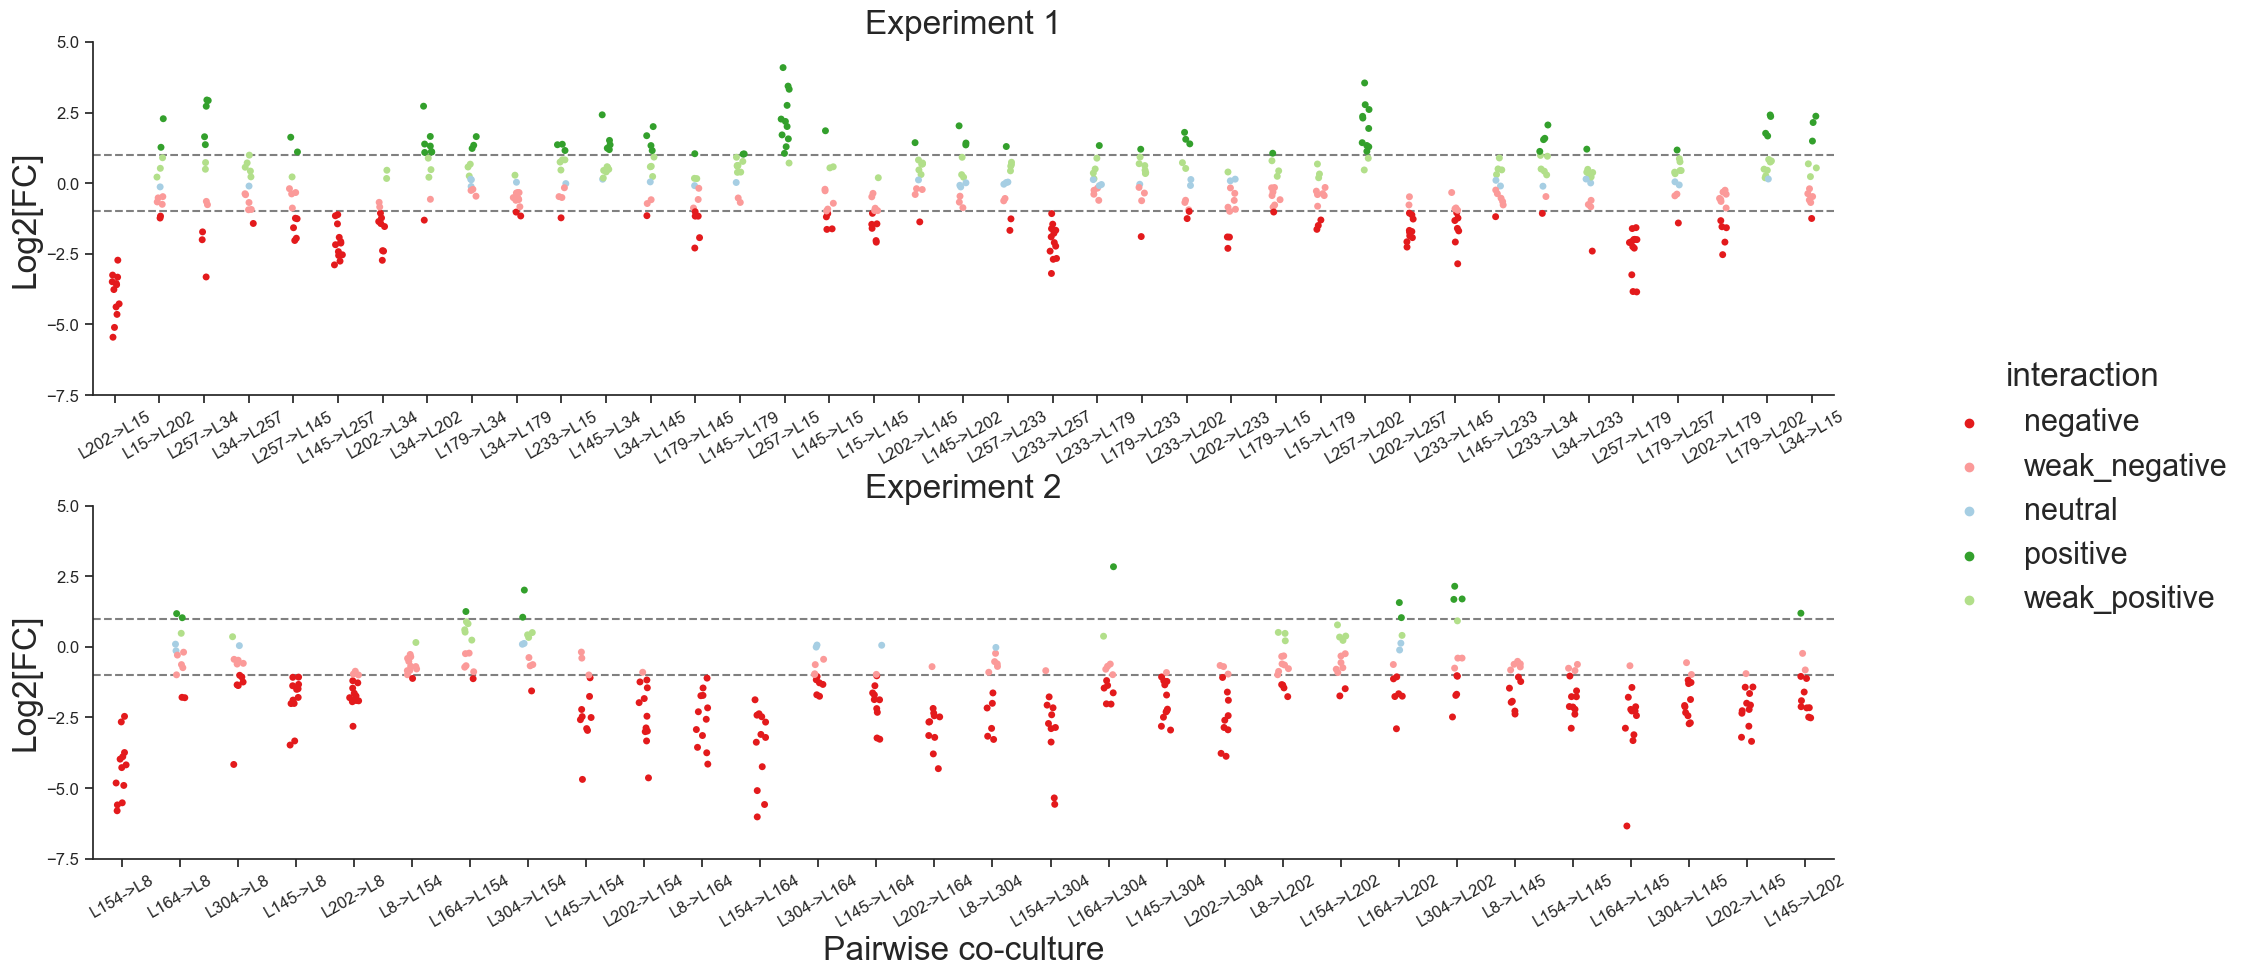

In [27]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=2)
g = sns.catplot(data=pairwise_exps_all, x="pair", y="Log2[FC]", sharex=False, row="exp", hue="interaction", aspect=4, kind="strip",  palette=palette)
g.refline(y=1, color="gray", linestyle="--")
g.refline(y=-1, color="gray", linestyle="--")
g.set_xlabels(label="Pairwise co-culture")
g.set_xticklabels(rotation=30, fontsize=12);
g.set_yticklabels(fontsize=12);
g.set_titles(template='{row_name}')
# plt.subplots_adjust(bottom=-0.3)
# plt.tight_layout()

## Read CommScores data

CommScores derived from the metabolic models reconstructed for each of the experimental microbial strains.

The following features are calculted:
1. Growth rates: Model1 growth rate, Model2 growth rate, Community growth rate
2. Metabolic Resource Overlap: MRO model1, MRO model2
3. Metabolic Interaction Potential: MIP model1, MIP model2, MIP costless model1, MIP costless model2
4. BioSynthetic score: BSS model1, BSS model2
5. PC: PC model1, PC model2, PC_comm
6. Growth yield difference: GYD
7. Biological interaction type: BIT
8. Functional similarity score: FS

Since, the interaction categorization derived from these experiments are undirected we average the values from both models in order to derived "undirected" features.

In [28]:
raw_commscores = pd.read_csv((rawdata_dir / "commscores_report.csv"), index_col=0).drop(["media"], axis=1)

In [29]:
with open((rawdata_dir / "gcf_leafid_map.txt")) as fid:
    gcf_leafid_rawmap = [line.strip().split("\t") for line in fid.readlines()]
gcf_leafid_map = {ids[0]: "L" + ids[2].split(" ")[-1].strip("Leaf") for ids in gcf_leafid_rawmap}

In [30]:
from utils import parse_commscores_data

In [31]:
commscores = parse_commscores_data(raw_commscores, gcf_leafid_map, dtype="directed")
commscores

,model1,model2,gr1,gr2,mro1,mro2,mip1,mip2,mip_c1,mip_c2,bss1,bss2,pc1,pc2
L202->L8,L8,L202,51.069,49.604,75.610,64.583,1,15,0,4,26.829,70.833,0.92348,0.84237
L8->L202,L202,L8,49.604,51.069,64.583,75.610,15,1,4,0,70.833,26.829,0.84237,0.92348
L257->L8,L8,L257,44.903,120.250,75.610,81.579,6,2,1,1,70.732,63.158,1.01110,1.00410
L8->L257,L257,L8,120.250,44.903,81.579,75.610,2,6,1,1,63.158,70.732,1.00410,1.01110
L145->L8,L8,L145,44.903,48.135,78.049,64.000,0,7,0,3,31.707,72.000,0.76616,0.71937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L164->L15,L15,L164,65.365,58.247,66.667,79.070,3,6,3,1,64.706,72.093,0.84928,0.95308
L233->L164,L164,L233,58.247,57.704,88.372,86.364,2,1,2,1,69.767,61.364,0.64999,0.65610
L164->L233,L233,L164,57.704,58.247,86.364,88.372,1,2,1,2,61.364,69.767,0.65610,0.64999
L233->L15,L15,L233,65.365,57.704,74.510,86.364,5,2,3,0,70.588,70.455,0.86554,0.98047


In [32]:
# Experimental set of micobes and verification
experimental_mono_microbes = set(monoculture_exps.microbe) - {"SynCom7"}
experimental_cocul_microbes = set(pairwise_exps.microbe1) | set(pairwise_exps.microbe2)
experimental_mono_microbes == experimental_cocul_microbes

True

In [33]:
# Computational set of microbes and missing models
models = set(commscores.model1) | set(commscores.model2)
print(f"Missing models {experimental_cocul_microbes - models}")

Missing models {'L304'}


In [34]:
data_raw_all = pairwise_exps.join(commscores, how="inner").drop(["microbe1", "microbe2", "model1", "model2"], axis=1)
data_raw_all = data_raw_all[data_raw_all.interaction.isin(interaction_filter_all)]
data_raw_nonneu = data_raw_all[data_raw_all.interaction.isin(interaction_filter_nonneu)]
data_raw_strong = data_raw_all[data_raw_all.interaction.isin(interaction_filter_strong)]

In [35]:
data_all = data_raw_all.drop(["colonization",  "Log2[FC]", "strain"], axis=1)
data_nonneu = data_raw_nonneu.drop(["colonization",  "Log2[FC]", "strain"], axis=1)
data_strong = data_raw_strong.drop(["colonization",  "Log2[FC]", "strain"], axis=1)

In [36]:
data_all.interaction.value_counts()

interaction
negative         22
weak_negative    16
weak_positive    12
neutral           6
positive          3
Name: count, dtype: int64

## Plot correlations

In [37]:
# Check with colonization
y = data_raw_strong.loc[:, "Log2[FC]"].copy(deep=True)
# cols_for_corr = ["gr_comm", "mro", "mip", "cip", "mip_c", "bss", "pc_comm", "gyd", "fs"]
cols_for_corr = ["gr1", "gr2", "mro1", "mro2", "mip1", "mip2", "mip_c1", "mip_c2", "bss1", "bss2", "pc1", "pc2"]
label_correlations = pd.Series({col: y.corr(data_raw_strong.loc[:, col]) for col in data_raw_strong.columns if col in cols_for_corr})
order = label_correlations.abs().sort_values()
label_correlations = label_correlations[order.index]
label_correlations_df = pd.DataFrame(data={"x": label_correlations.index, "y": label_correlations.values})

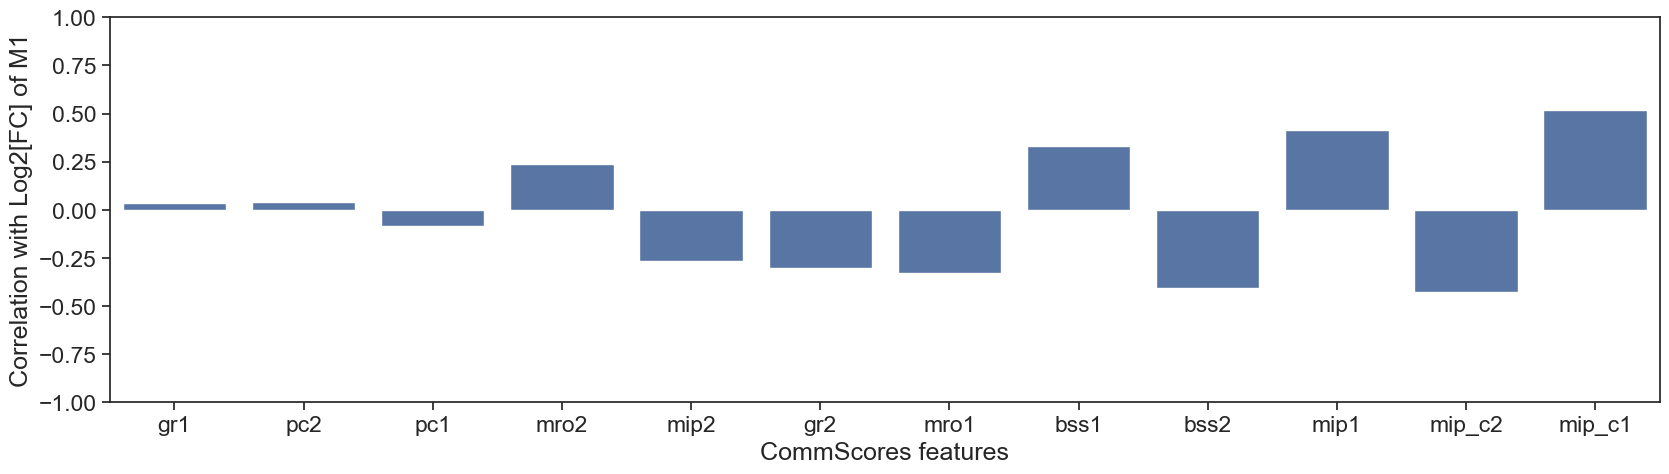

In [38]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.barplot(data=label_correlations_df, x="x", y="y", color="b")
g.set(xlabel="CommScores features", ylabel="Correlation with Log2[FC] of M1", ylim=(-1, 1));

In [39]:
data_melt_all = data_all.drop(["exp"], axis=1).melt(id_vars=["interaction"], var_name="column")
data_melt_nonneu = data_nonneu.drop(["exp"], axis=1).melt(id_vars=["interaction"], var_name="column")
data_melt_strong = data_strong.drop(["exp"], axis=1).melt(id_vars=["interaction"], var_name="column")
data_melt_all

,interaction,column,value
0,weak_negative,gr1,65.36500
1,negative,gr1,51.34100
2,negative,gr1,58.24700
3,weak_positive,gr1,48.35700
4,neutral,gr1,49.22600
...,...,...,...
703,weak_negative,pc2,0.52936
704,negative,pc2,0.76616
705,weak_negative,pc2,1.03640
706,negative,pc2,0.99881


## Plot distribution of CommScores metrics

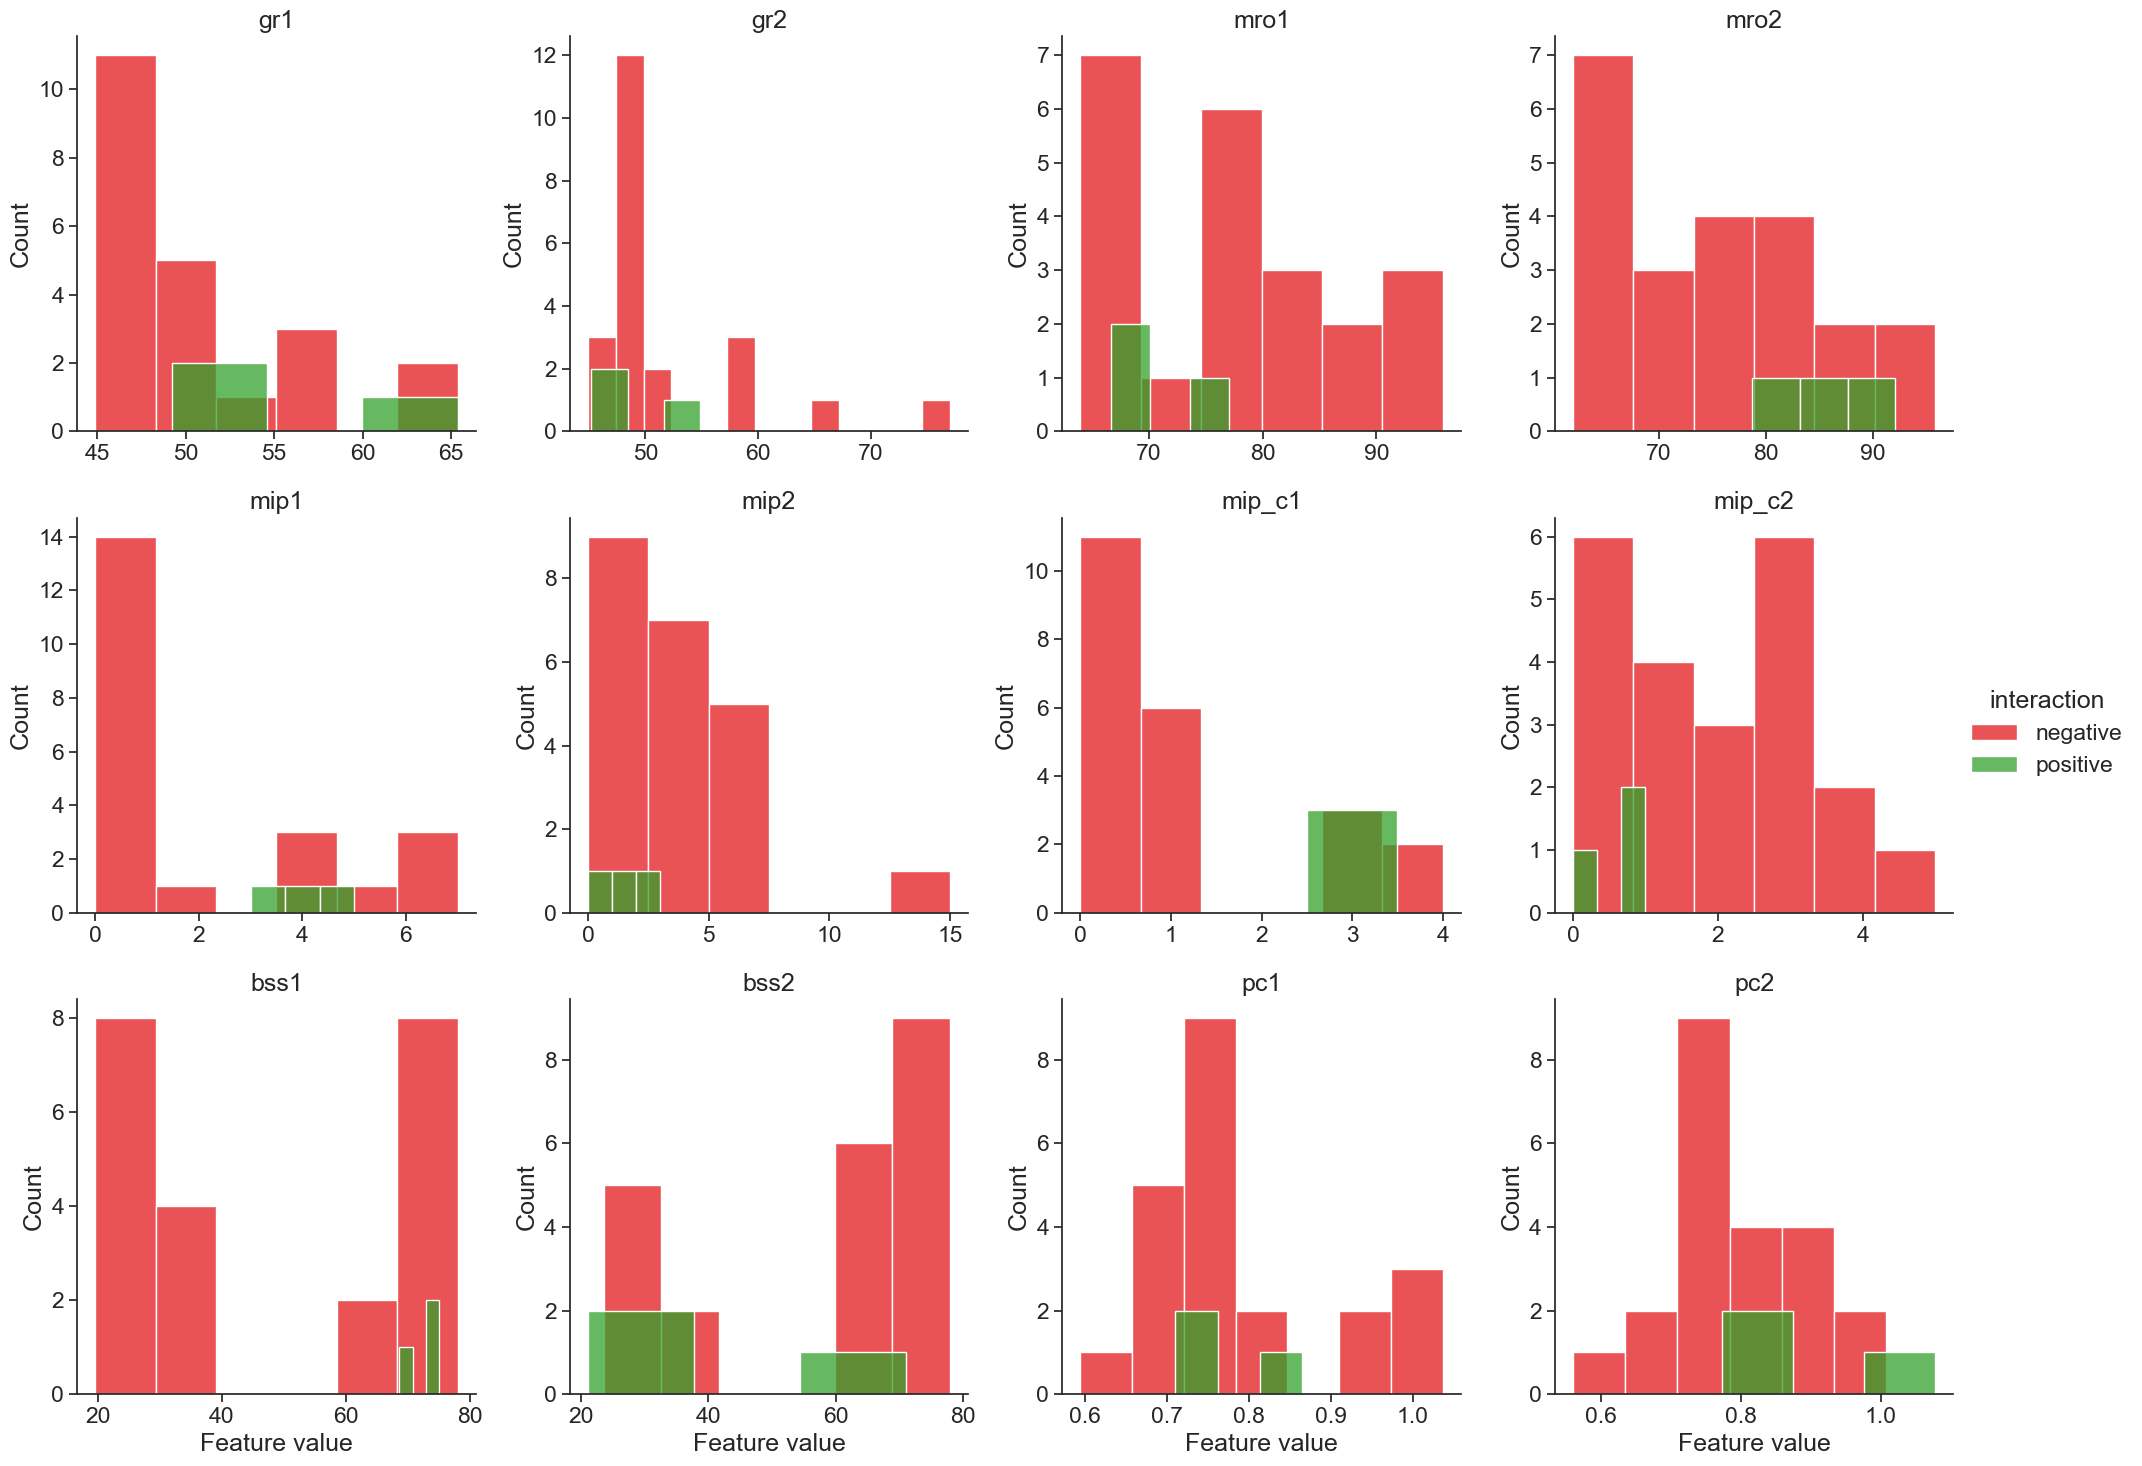

In [40]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data_melt_strong, col="column", col_wrap=4, sharex=False, sharey=False, hue="interaction", height=5, palette=palette)
# g.map_dataframe(sns.histplot, x="value", stat="count", common_norm=False, element="step", bins=10)
g.map_dataframe(sns.histplot, x="value", stat="count")
g.set_xlabels(label="Feature value")
g.set_titles(template="{col_name}")
g.add_legend()

In [41]:
data_melt_all_numeric = data_melt_all.loc[data_melt_all.column != "bit", :]
data_melt_nonneu_numeric = data_melt_nonneu.loc[data_melt_nonneu.column != "bit", :]
data_melt_strong_numeric = data_melt_strong.loc[data_melt_strong.column != "bit", :]

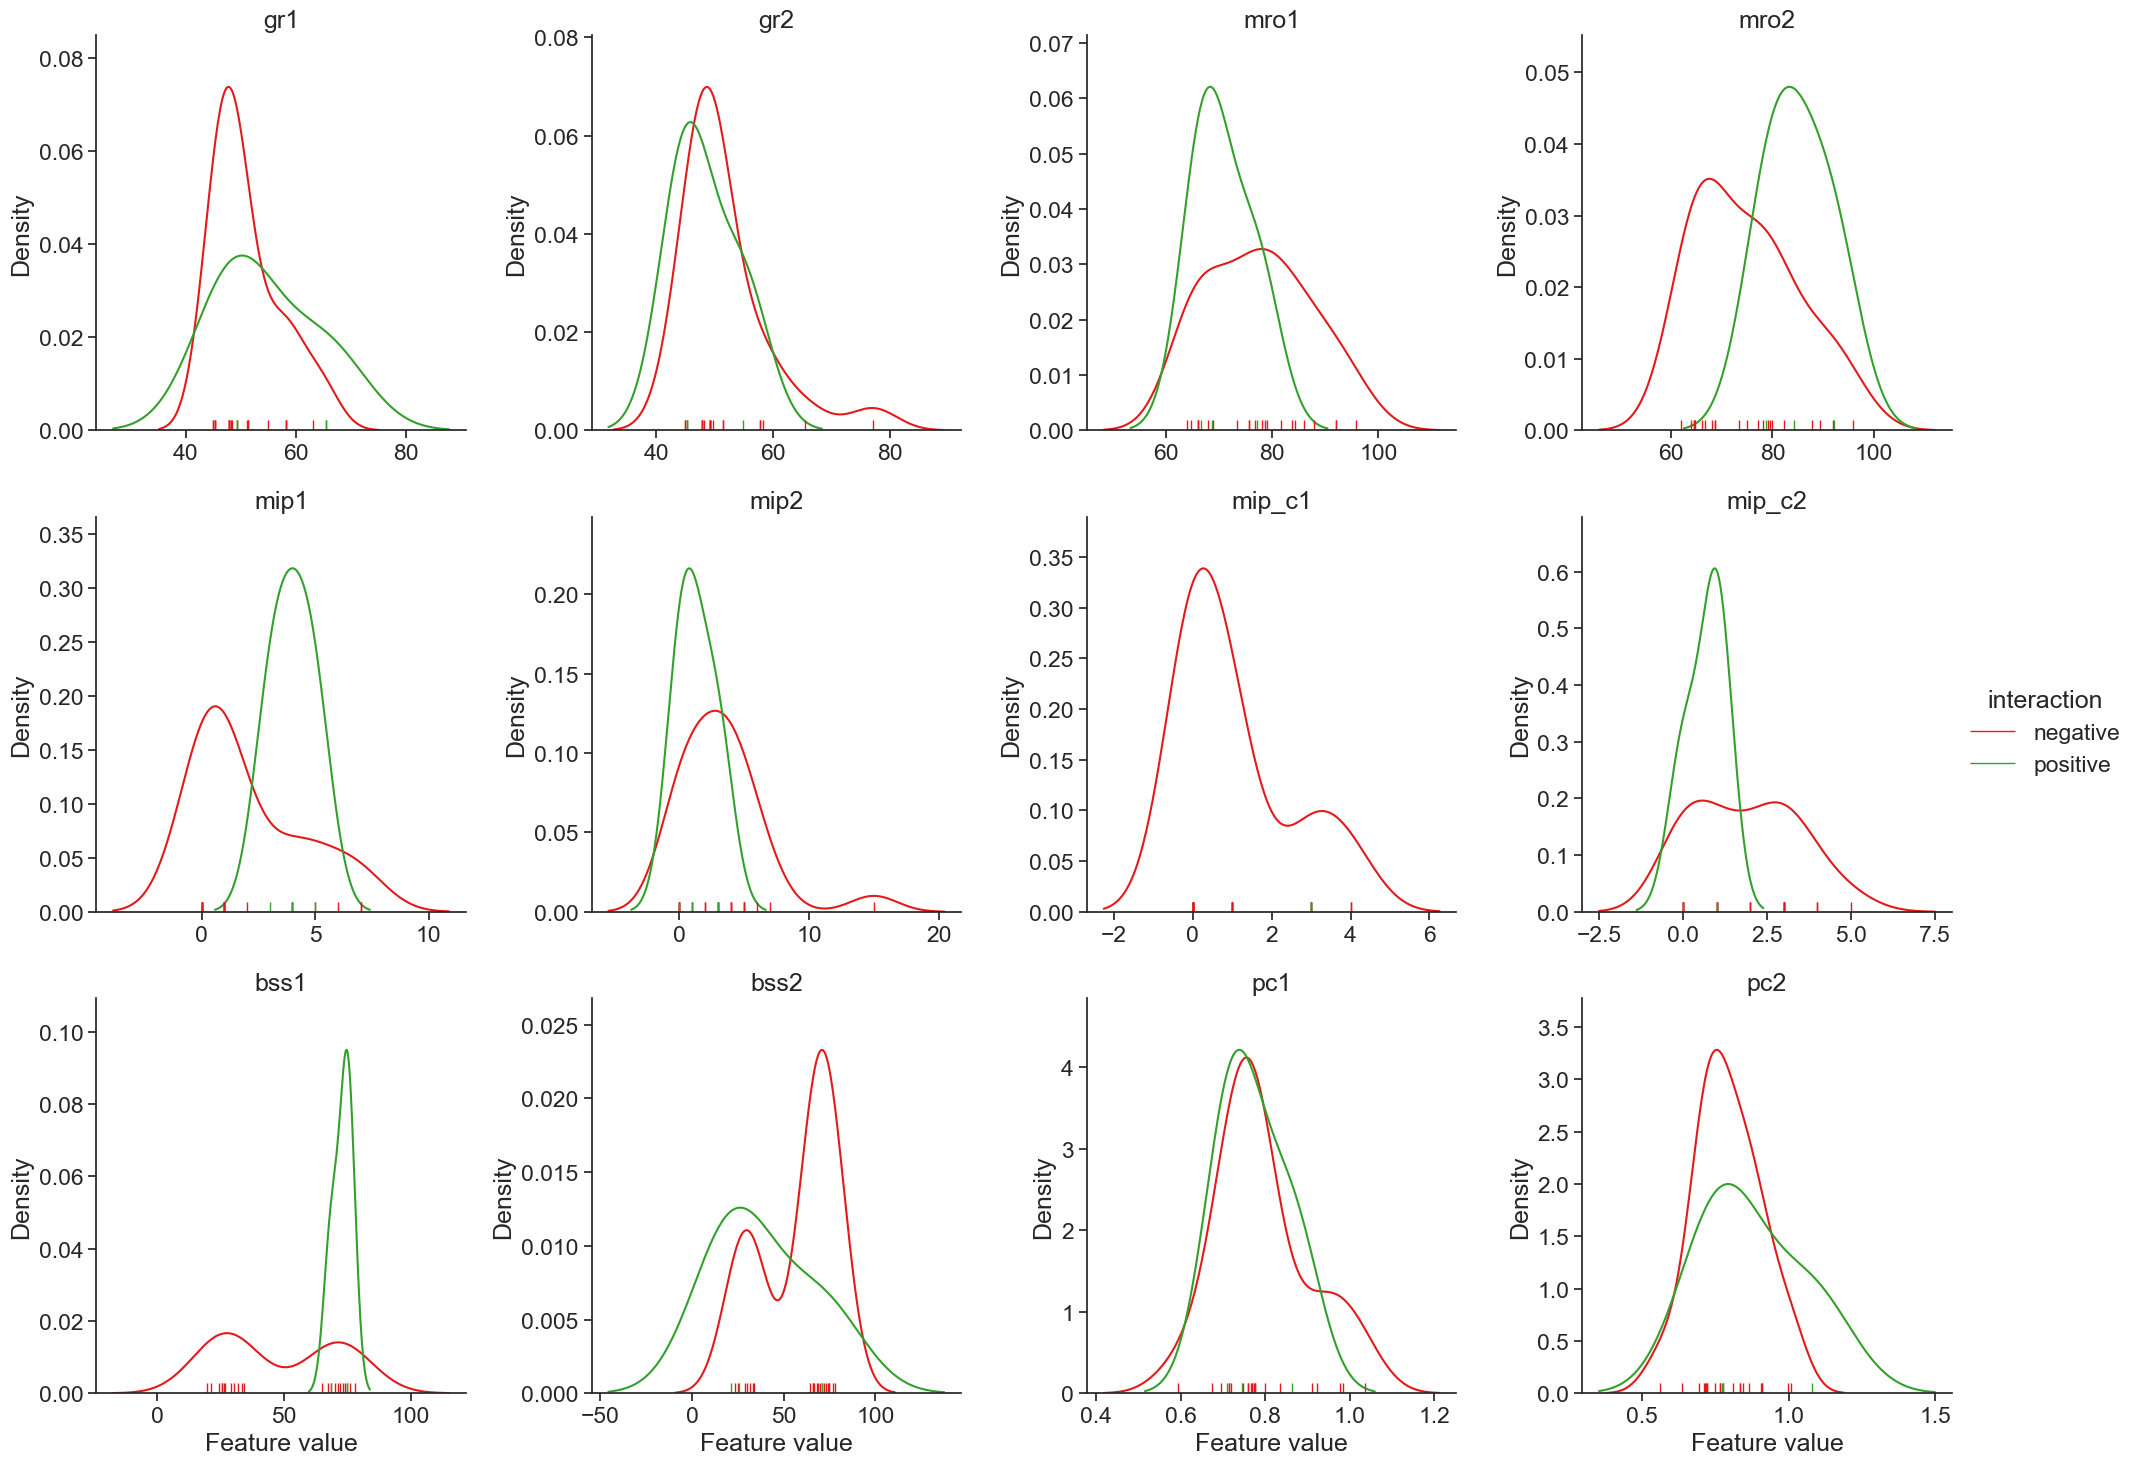

In [42]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data_melt_strong_numeric, col="column", col_wrap=4, sharex=False, sharey=False, hue="interaction", height=5, palette=palette);
g.map_dataframe(sns.kdeplot, x="value");
g.map_dataframe(sns.rugplot, x="value");
g.set_titles(template="{col_name}")
g.set_xlabels(label="Feature value")
g.add_legend()

## Plot statistical significance between CommScores metrics in different interaction categories

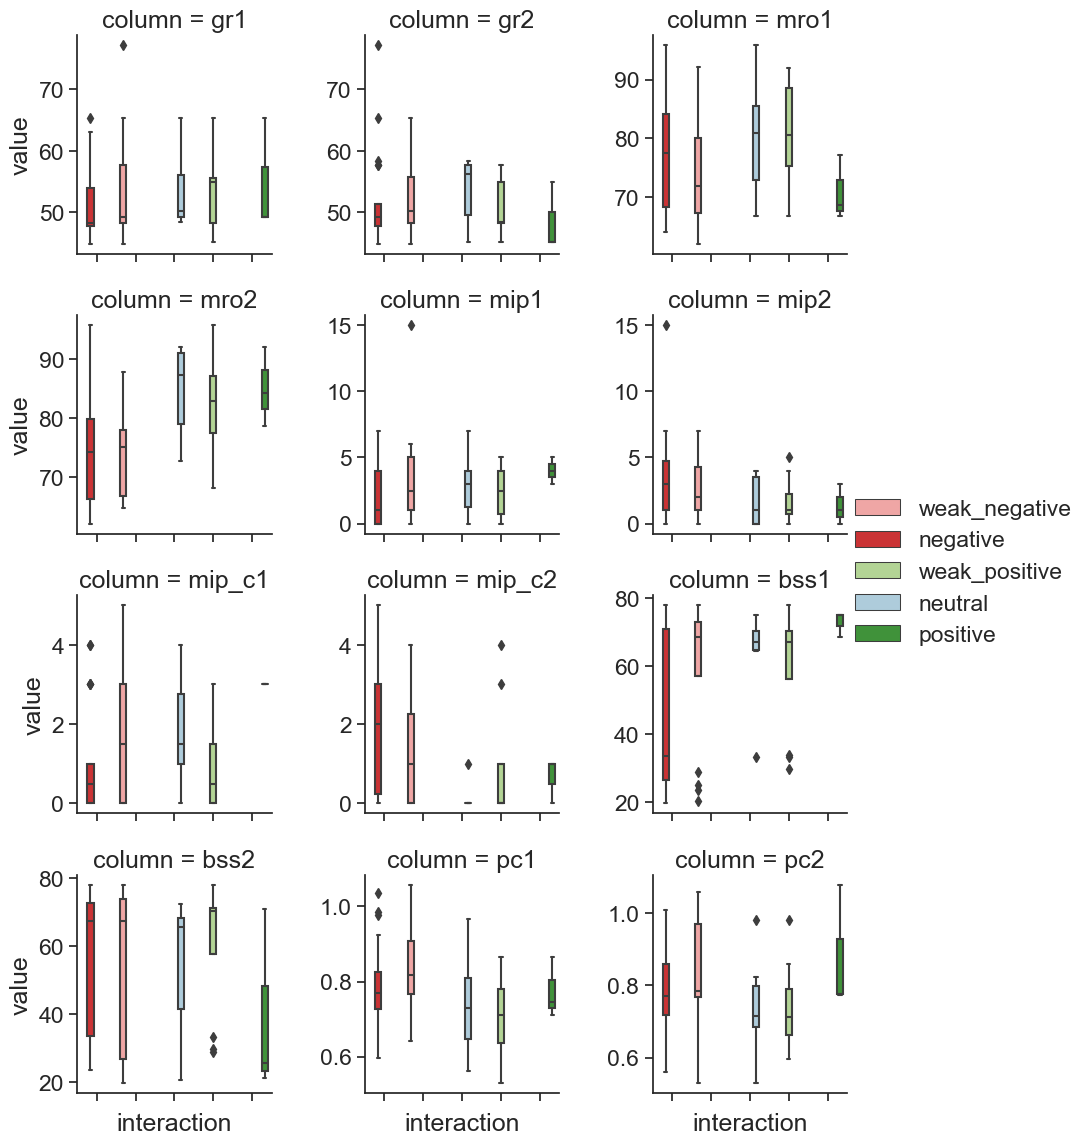

In [43]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data=data_melt_all_numeric, col="column", col_wrap=3, sharey=False)
g.map_dataframe(sns.boxplot, x="interaction", y="value", order=interaction_filter_all, hue="interaction", palette=palette)
g.add_legend()
g.set_xticklabels(rotation=30)

In [44]:
from statannotations.Annotator import Annotator

In [45]:
pairs = [("positive", "negative"),]
plotting_parameters = {
    "x": "interaction",
    "y": "value",
    "order": interaction_filter_all,
    "palette": palette
}
annotator = Annotator(None, pairs)

negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.737e-01 U_stat=1.950e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.751e-01 U_stat=4.400e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.795e-01 U_stat=4.400e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.028e-01 U_stat=1.300e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.574e-01 U_stat=1.600e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.706e-01 U_stat=4.650e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.091e-02 U_stat=1.050e+01
negative vs. positive: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.467e-01 U_stat=4.700e+01
negative vs. positive: Mann-Whit

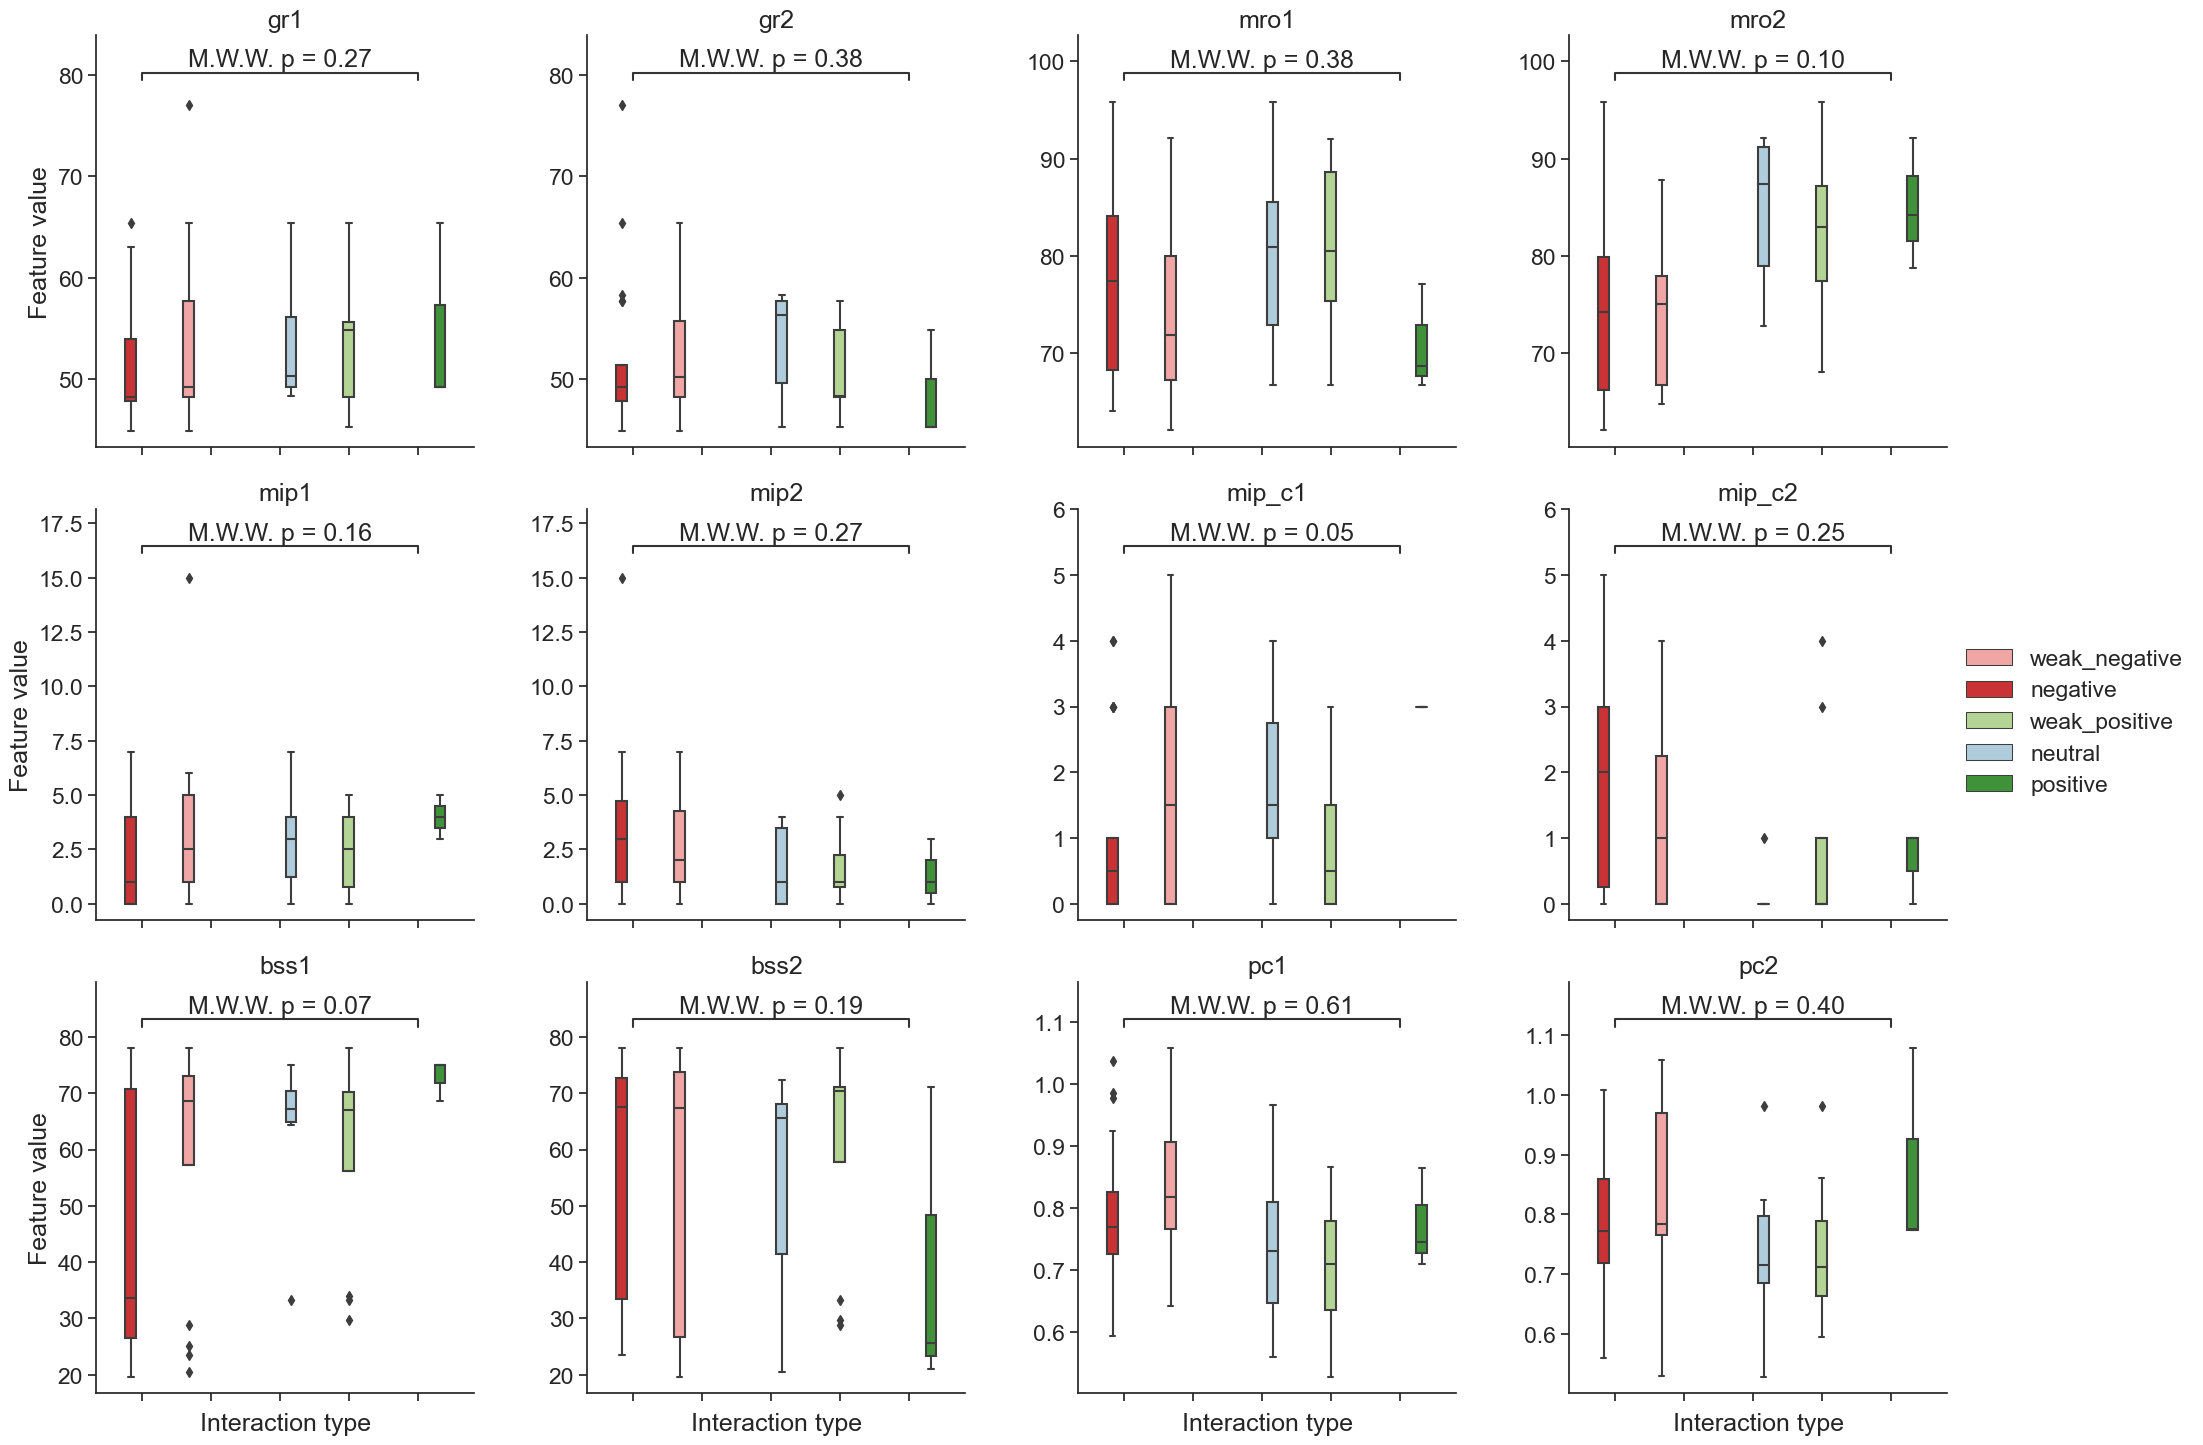

In [46]:
sns.set_theme(style="ticks", rc={"figure.figsize":(20, 5)}, font_scale=1.5)
g = sns.FacetGrid(data=data_melt_all_numeric, col="column", sharey=False,  col_wrap=4, height=5)
g.map_dataframe(annotator.plot_and_annotate_facets, plot="boxplot", hue="interaction", plot_params=plotting_parameters, configuration={"test": "Mann-Whitney", "comparisons_correction": "bonf", "text_format": "simple"}, annotation_func="apply_test");
g.set_xlabels(label="Interaction type")
g.set_ylabels(label="Feature value")
g.set_titles(template="{col_name}")
g.set_xticklabels(rotation=30)
g.add_legend()

## Correlations between models and experiments

In [47]:
gr_dict = dict()
for _, row in commscores.iterrows():
    key1 = row.model1
    value1 = row.gr1
    key2 = row.model2
    value2 = row.gr2
    gr_dict[key1] = value1
    gr_dict[key2] = value2
gr_df = pd.Series(gr_dict)
gr_df.name = "gr"

In [48]:
monoculture_gr = monoculture_exps.join(gr_df, how="inner")
monoculture_gr.index = range(monoculture_gr.shape[0])
monoculture_gr["Log10[C]"] = np.log10(monoculture_gr["colonization"])
monoculture_gr

,microbe,colonization,dilution,exp,gr,Log10[C]
0,L145,4.637548e+08,0.0001,Experiment 1,47.823,8.666288
1,L145,1.319442e+08,0.0010,Experiment 2,47.823,8.120390
2,L15,4.573082e+07,0.0010,Experiment 1,65.365,7.660209
3,L154,1.014106e+08,0.0010,Experiment 2,51.341,8.006083
4,L164,3.404024e+07,0.0010,Experiment 2,58.247,7.531993
5,L179,2.234598e+08,0.0001,Experiment 1,48.357,8.349199
6,L202,1.321754e+08,0.0010,Experiment 1,49.226,8.121151
7,L202,8.552140e+07,0.0010,Experiment 2,49.226,7.932075
8,L233,3.528796e+08,0.0001,Experiment 1,57.704,8.547626
9,L257,4.267570e+08,0.0001,Experiment 1,45.215,8.630181


<Axes: xlabel='Log10[C]', ylabel='gr'>

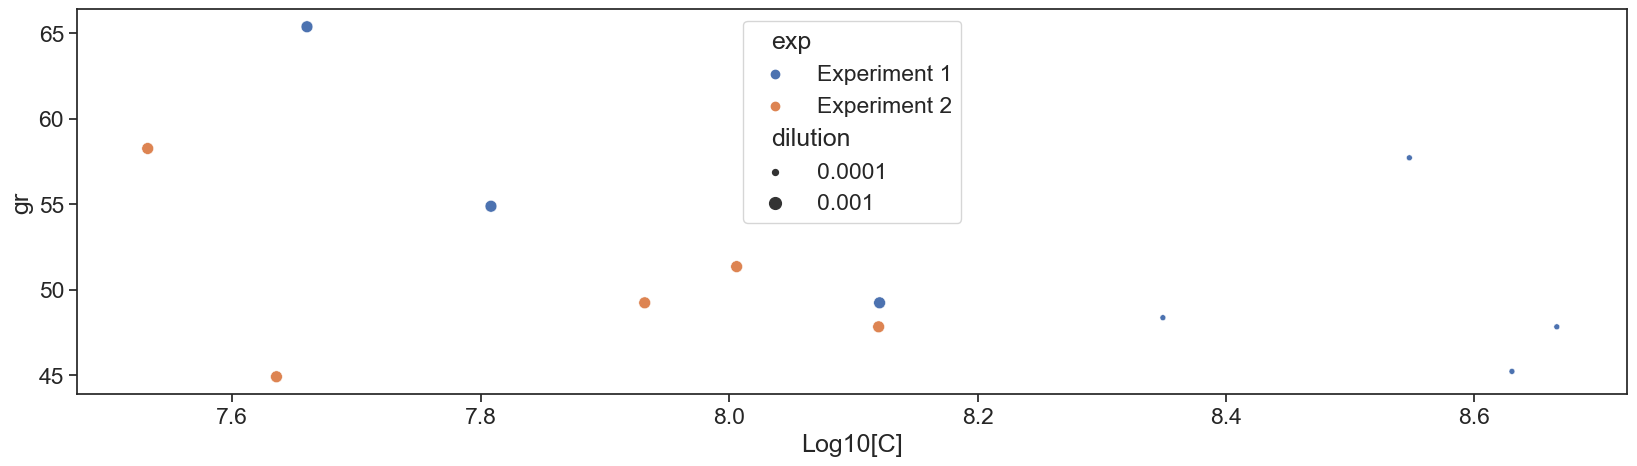

In [49]:
sns.scatterplot(data=monoculture_gr, x="Log10[C]", y="gr", hue="exp", size="dilution")

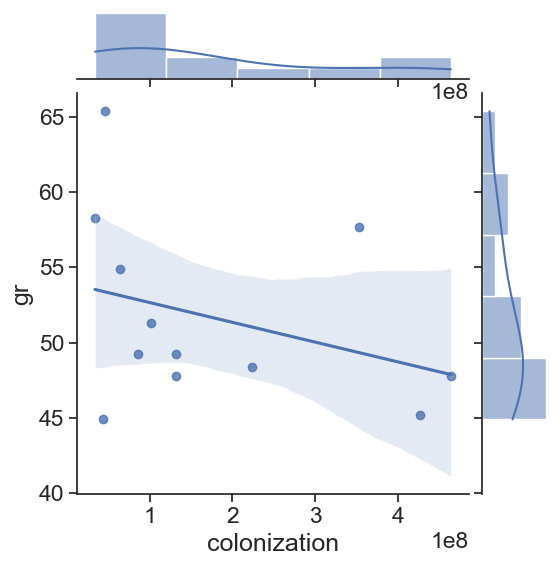

In [50]:
sns.jointplot(data=monoculture_gr, x="colonization", y="gr", kind="reg")

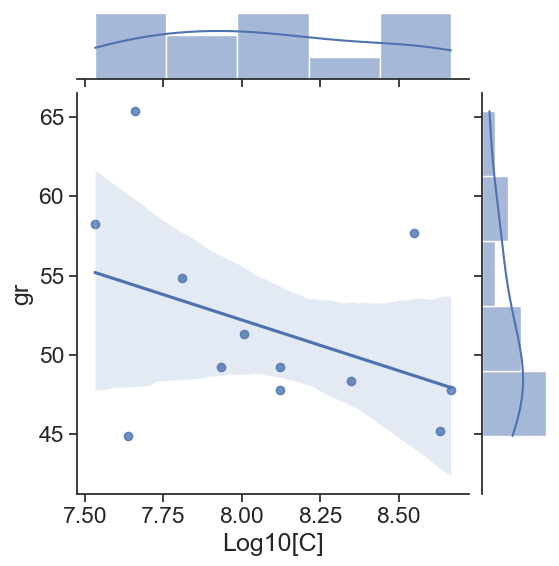

In [51]:
sns.jointplot(data=monoculture_gr, x="Log10[C]", y="gr", kind="reg")

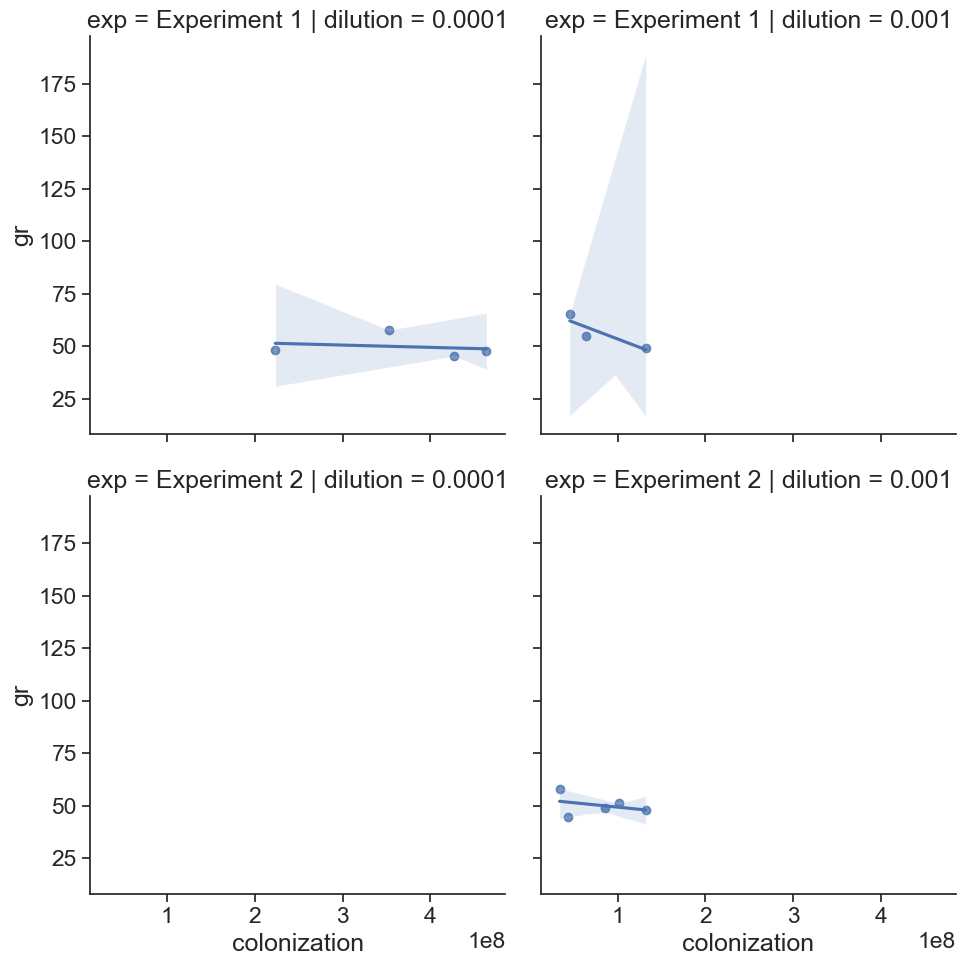

In [52]:
sns.lmplot(data=monoculture_gr, x="colonization", y="gr", row="exp", col="dilution")

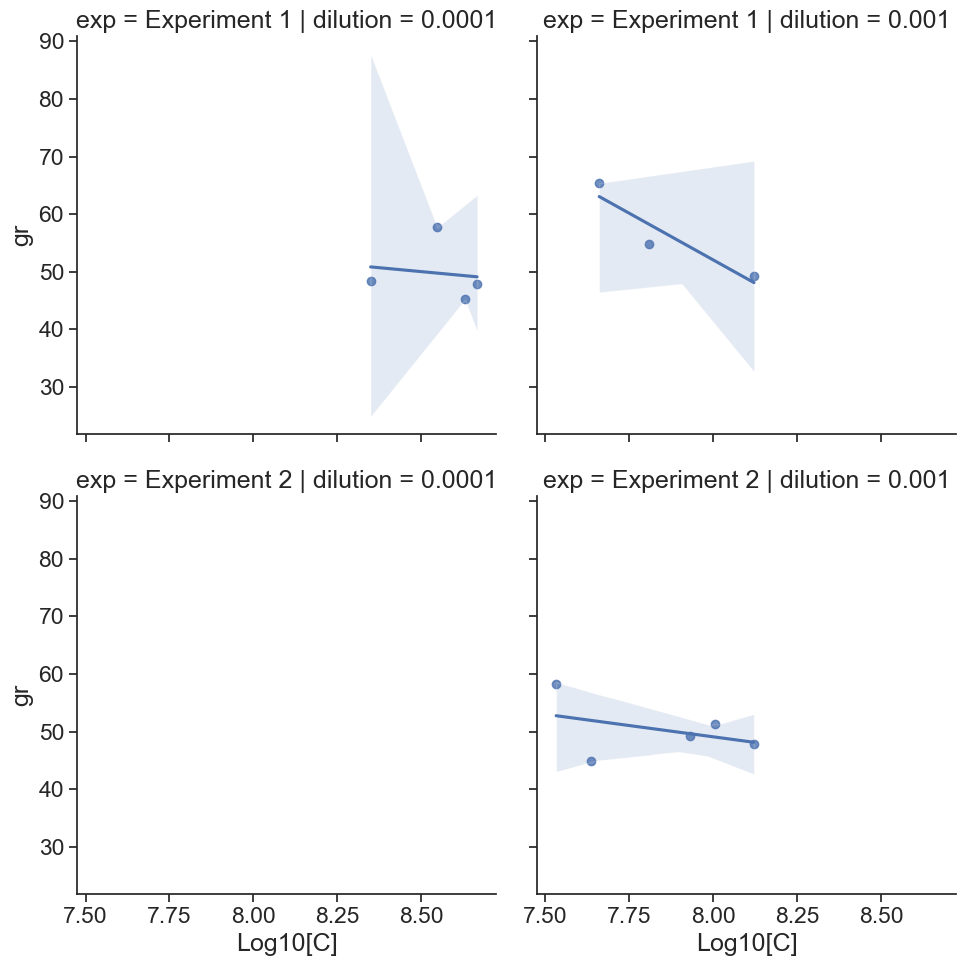

In [53]:
sns.lmplot(data=monoculture_gr, x="Log10[C]", y="gr", row="exp", col="dilution")

In [54]:
data_raw_all = pairwise_exps.join(commscores, how="inner").drop(["microbe1", "microbe2", "model1", "model2"], axis=1)
data_raw_all = data_raw_all[data_raw_all.interaction.isin(interaction_filter_all)]

In [55]:
y = data_raw_all.loc[:, "gr1"].copy(deep=True)
cols_for_corr = ["colonization", "Log2[FC]"]
label_correlations = pd.Series({col: y.corr(data_raw_all.loc[:, col]) for col in data_raw_all.columns if col in cols_for_corr})
order = label_correlations.abs().sort_values()
label_correlations = label_correlations[order.index]

<Axes: xlabel='feature', ylabel='correlation with gr_comm'>

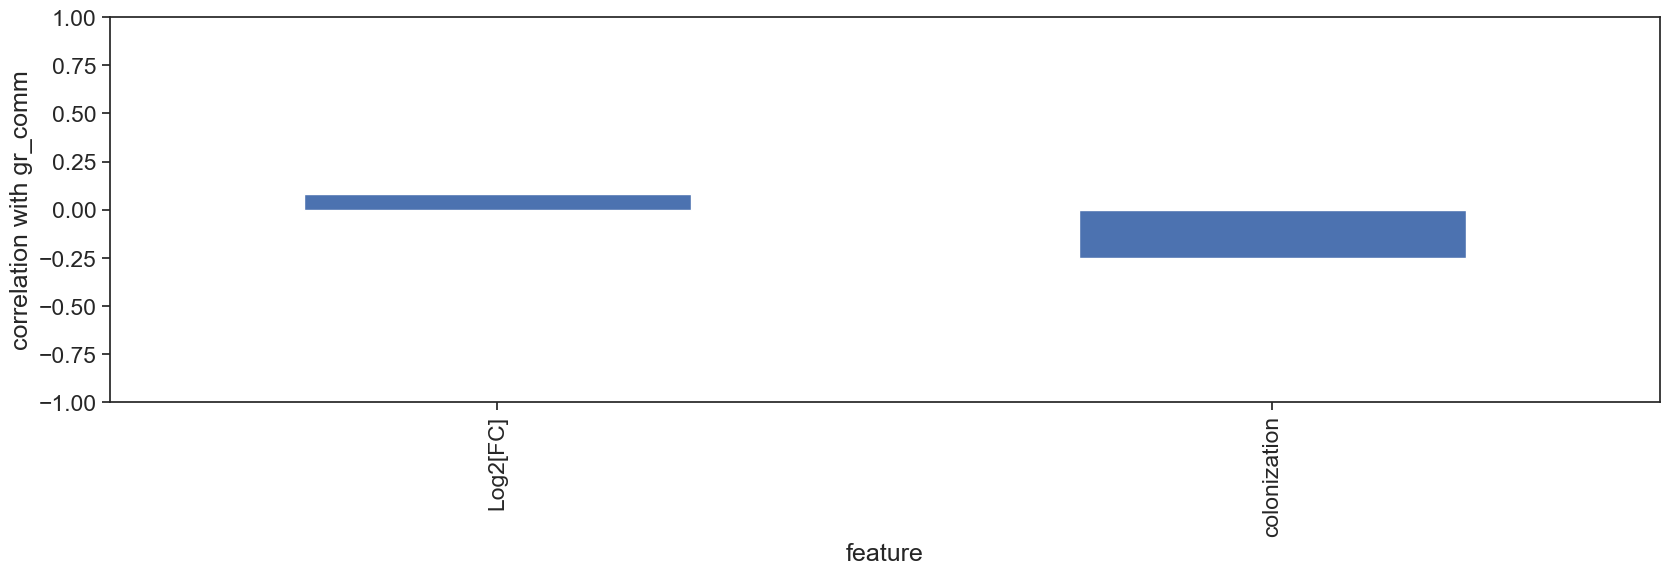

In [56]:
%matplotlib inline
label_correlations.plot(kind="bar", xlabel="feature", ylabel="correlation with gr_comm", ylim=(-1,1))